## Pre-processing

In [1]:
!wget https://github.com/kairess/toy-datasets/raw/master/personal-color-dataset.zip
!unzip -q personal-color-dataset.zip

--2024-09-11 10:31:28--  https://github.com/kairess/toy-datasets/raw/master/personal-color-dataset.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kairess/toy-datasets/master/personal-color-dataset.zip [following]
--2024-09-11 10:31:28--  https://raw.githubusercontent.com/kairess/toy-datasets/master/personal-color-dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31307118 (30M) [application/zip]
Saving to: ‘personal-color-dataset.zip.1’

personal-color-data 100%[===================>]  29.86M  --.-KB/s    in 0.08s   

2024-09-11 10:31:28 (385 MB/s) - ‘personal-color-dataset.zip.

## Collect more pictures using jmd_imagescraper & DuckDuckGo

In [2]:
# Install the package
!pip install -q jmd_imagescraper

### 패키지 로드

In [17]:
# Load the package
from jmd_imagescraper.core import *
from jmd_imagescraper.imagecleaner import *

In [18]:
from enum import Enum
import re
import requests
import json
import time
from pathlib import Path
from typing import Union

class ImgSize(Enum):
    Cached=""
    Small="Small"
    Medium="Medium"
    Large="Large"
    Wallpaper="Wallpaper"

class ImgLayout(Enum):
    All=""
    Square="Square"
    Tall="Tall"
    Wide="Wide"

class ImgType(Enum):
    All=""
    Photo="photo"
    Clipart="clipart"
    Gif="gif"
    Transparent="transparent"

class ImgColor(Enum):
    All=""
    Color="color"
    Monochrome="Monochrome"
    Red="Red"
    Orange="Orange"
    Yellow="Yellow"
    Green="Green"
    Blue="Blue"
    Purple="Purple"
    Pink="Pink"
    Brown="Brown"
    Black="Black"
    Gray="Gray"
    Teal="Teal"
    White="White"

def duckduckgo_scrape_urls_custom(keywords: str, max_results: int,
                                    img_size: ImgSize=ImgSize.Cached,
                                    img_type: ImgType=ImgType.Photo,
                                    img_layout: ImgLayout=ImgLayout.Square,
                                    img_color: ImgColor=ImgColor.All) -> list:
    '''Scrapes URLs from DuckDuckGo image search. Returns list of URLs.'''
    BASE_URL = 'https://duckduckgo.com/'
    params = {
        'q': keywords
    };
    results = 0
    links = []

    resp = requests.post(BASE_URL, data=params, headers={'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36'})
    match = re.search(r'vqd=([\d-]+)\&', resp.text, re.M|re.I)
    assert match is not None, "Failed to obtain search token"

    HEADERS = {
        'authority': 'duckduckgo.com',
        'accept': 'application/json, text/javascript, */*; q=0.01',
        'sec-fetch-dest': 'empty',
        'x-requested-with': 'XMLHttpRequest',
        'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36',
        'sec-fetch-site': 'same-origin',
        'sec-fetch-mode': 'cors',
        'referer': 'https://duckduckgo.com/',
        'accept-language': 'en-US,en;q=0.9',
      }

    filters = ""
    if(img_size != ImgSize.Cached): filters +=  "size:" + img_size.name
    filters += ","
    if(img_type != ImgType.All): filters +=  "type:" + img_type.name
    filters += ","
    if(img_layout != ImgLayout.All): filters +=  "layout:" + img_layout.name
    filters += ","
    if(img_color != ImgColor.All): filters +=  "color:" + img_color.name

    PARAMS = (
        ('l', 'us-en'),
        ('o', 'json'),
        ('q', keywords),
        ('vqd', match.group(1)),
        ('f', filters),
        ('p', '1'),
        ('v7exp', 'a'),
    )

    requestUrl = BASE_URL + "i.js"

    while True:
        while True:
            try:
                resp = requests.get(requestUrl, headers=HEADERS, params=PARAMS)
                data = json.loads(resp.text)
                break
            except ValueError as e:
                print("Hit request throttle, sleeping and retrying")
                time.sleep(5)
                continue

        for result in data["results"]:
            if(img_size == ImgSize.Cached): links.append(result["thumbnail"])
            else:                           links.append(result["image"])

            if(max_results is not None):
                if(len(links) >= max_results) : return links

        if "next" not in data:
            #no next page, all done
            return links

        requestUrl = BASE_URL + data["next"]

def duckduckgo_search_custom(path: Union[str, Path], label: str, keywords: str, max_results: int=100,
                                img_size: ImgSize=ImgSize.Cached,
                                img_type: ImgType=ImgType.Photo,
                                img_layout: ImgLayout=ImgLayout.Square,
                                img_color: ImgColor=ImgColor.All,
                                uuid_names: bool=True) -> list:
    '''Run a DuckDuckGo search and download the images. Returns a list of Path objects for files downloaded to disc.'''

    print("Duckduckgo search:", keywords)
    links = duckduckgo_scrape_urls_custom(keywords, max_results, img_size, img_type, img_layout, img_color)
    return download_urls(Path(path)/label, links, uuid_names=uuid_names)

In [5]:
# Collect more pictures for training
tones = {
    'Spring Warm': ['배수지', '송혜교', '아이유', '한지민', '유인나', '김세정', '윤아', '혜리'],
    'Autumn Warm': ['이성경', '이효리', '고준희', '정유미', '김민희', '박신혜', '한지민', '송혜교', '한효주'],
    'Spring Cool': ['정채연', '아이린', '손예진', '하니', '서지혜', '박시연', '태연', '김고은', '이영애', '장원영'],
    'Winter Cool': ['선미', '현아', '민효린', '티파니', '김혜수', '이나영', '카리나', '김서형', '이다희']
}

path = 'train'
max_results = 100

for tone, names in tones.items():
    label = tone

    for name in names:
        keywords = name

        image_list = duckduckgo_search_custom(
            path=path,
            label=label,
            keywords=keywords,
            max_results=max_results
        )

Duckduckgo search: 배수지


Duckduckgo search: 송혜교


Duckduckgo search: 아이유


Duckduckgo search: 한지민


Duckduckgo search: 유인나


Duckduckgo search: 김세정


Duckduckgo search: 윤아


Duckduckgo search: 혜리


Duckduckgo search: 이성경


Duckduckgo search: 이효리


Duckduckgo search: 고준희


Duckduckgo search: 정유미


Duckduckgo search: 김민희


Duckduckgo search: 박신혜


Duckduckgo search: 한지민


Duckduckgo search: 송혜교


Duckduckgo search: 한효주


Duckduckgo search: 정채연


Duckduckgo search: 아이린


Duckduckgo search: 손예진


Duckduckgo search: 하니


Duckduckgo search: 서지혜


Duckduckgo search: 박시연


Duckduckgo search: 태연


Duckduckgo search: 김고은


Duckduckgo search: 이영애


Duckduckgo search: 장원영


Duckduckgo search: 선미


Duckduckgo search: 현아


Duckduckgo search: 민효린


Duckduckgo search: 티파니


Duckduckgo search: 김혜수


Duckduckgo search: 이나영


Duckduckgo search: 카리나


Duckduckgo search: 김서형


Duckduckgo search: 이다희


In [19]:
# Move the image from the Korean named folder in dataset
import os
import shutil

# Define the name mapping from Korean to English
name_mapping = {
    '가을 웜톤': 'Autumn Warm',
    '겨울 쿨톤': 'Winter Cool',
    '봄 웜톤': 'Spring Warm',
    '여름 쿨톤': 'Summer Cool'
}

# Define the source folderand target folder
source_dir = 'train/'
target_dir = 'train/'

# Loop through each folder in the source directory
for korean_name, english_name in name_mapping.items():
    src_folder = os.path.join(source_dir, korean_name)
    dst_folder = os.path.join(target_dir, english_name)

    # Check if the source folder exists
    if os.path.exists(src_folder):
        # Create the target folder if it doesn't exist
        if not os.path.exists(dst_folder):
            os.makedirs(dst_folder)

        # Move all files from the source folder to the destination folder
        for file_name in os.listdir(src_folder):
            src_file = os.path.join(src_folder, file_name)
            dst_file = os.path.join(dst_folder, file_name)
            shutil.move(src_file, dst_file)

        # Remove the empty source folder after moving
        os.rmdir(src_folder)

print("Files moved successfully!")

Files moved successfully!


In [20]:
# Define the name mapping from Korean to English
name_mapping = {
    '가을 웜톤': 'Autumn Warm',
    '겨울 쿨톤': 'Winter Cool',
    '봄 웜톤': 'Spring Warm',
    '여름 쿨톤': 'Summer Cool'
}

# Define the source folderand target folder
source_dir = 'test/'
target_dir = 'test/'

# Loop through each folder in the source directory
for korean_name, english_name in name_mapping.items():
    src_folder = os.path.join(source_dir, korean_name)
    dst_folder = os.path.join(target_dir, english_name)

    # Check if the source folder exists
    if os.path.exists(src_folder):
        # Create the target folder if it doesn't exist
        if not os.path.exists(dst_folder):
            os.makedirs(dst_folder)

        # Move all files from the source folder to the destination folder
        for file_name in os.listdir(src_folder):
            src_file = os.path.join(src_folder, file_name)
            dst_file = os.path.join(dst_folder, file_name)
            shutil.move(src_file, dst_file)

        # Remove the empty source folder after moving
        os.rmdir(src_folder)

print("Files moved successfully!")

Files moved successfully!


## Prepare the data for training

### Use the mediapipe

In [21]:
!pip install -q mediapipe

In [22]:
import mediapipe as mp
import cv2
from google.colab.patches import cv2_imshow

In [23]:
mp_face_detection = mp.solutions.face_detection

mp_drawing = mp.solutions.drawing_utils
drawing_spec = mp_drawing.DrawingSpec()

face_detection = mp_face_detection.FaceDetection(
    min_detection_confidence=0.8)

### Cut the face area from the whole picture

In [24]:
# Training Data
from glob import glob
import os

tones = ['Autumn Warm', 'Winter Cool', 'Spring Warm', 'Summer Cool']

for tone in tones:
    path = f'train/{tone}/*.*'
    result_path = f'train_face/{tone}'

    os.makedirs(result_path, exist_ok=True)

    img_list = glob(path)

    for i, img_path in enumerate(img_list):
        img = cv2.imread(img_path)

        results = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        if results.detections:
            for detection in results.detections:
                box = detection.location_data.relative_bounding_box

                xmin = max(int(box.xmin * img.shape[1]), 0)
                ymin = max(int(box.ymin * img.shape[0]), 0)
                width = int(box.width * img.shape[1])
                height = int(box.height * img.shape[0])

                face_img = img[ymin:ymin + height, xmin:xmin + width]

                num = str(i).zfill(3)

                cv2.imwrite(f'{result_path}/face_{num}.jpg', face_img)

/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


In [25]:
# Test Data
tones = ['Autumn Warm', 'Winter Cool', 'Spring Warm', 'Summer Cool']

for tone in tones:
    path = f'test/{tone}/*.*'
    result_path = f'test_face/{tone}'

    os.makedirs(result_path, exist_ok=True)

    img_list = glob(path)

    for i, img_path in enumerate(img_list):
        img = cv2.imread(img_path)

        results = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        if results.detections:
            for detection in results.detections:
                box = detection.location_data.relative_bounding_box

                xmin = max(int(box.xmin * img.shape[1]), 0)
                ymin = max(int(box.ymin * img.shape[0]), 0)
                width = int(box.width * img.shape[1])
                height = int(box.height * img.shape[0])

                face_img = img[ymin:ymin + height, xmin:xmin + width]

                num = str(i).zfill(3)

                cv2.imwrite(f'{result_path}/face_{num}.jpg', face_img)

In [26]:
# Load the Packages
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

## Data loader

Data augmentation techniques have been added to increase accuracy.

10363 40


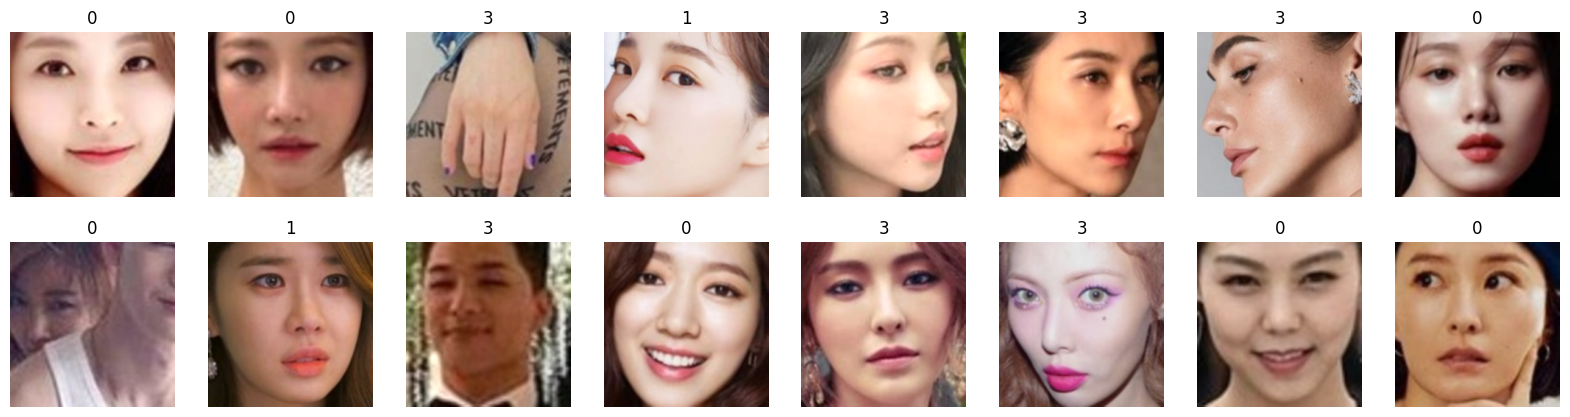

In [27]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(), # Left and right inverted randomization
        transforms.ColorJitter(brightness=0.1, contrast=0, saturation=0, hue=0), # Randomize image brightness
        transforms.GaussianBlur(kernel_size=3, sigma=(0.5, 1.5)), # Randomize image blur
        transforms.ToTensor(),
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

image_datasets = {
    'train': datasets.ImageFolder('train_face', data_transforms['train']),
    'validation': datasets.ImageFolder('test_face', data_transforms['validation'])
}

dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'],
        batch_size=16,
        shuffle=True),
    'validation': torch.utils.data.DataLoader(
        image_datasets['validation'],
        batch_size=10,
        shuffle=False)
}

print(len(image_datasets['train']), len(image_datasets['validation']))

imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(2, 8, figsize=(20, 5))

for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')

### Check the Class Name

In [30]:
image_datasets['train'].classes

['Autumn Warm', 'Spring Warm', 'Summer Cool', 'Winter Cool']

## Pre-trained MobileNetV3 Model

In [33]:
import torch
import torchvision.models as models

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v3_small(weights='IMAGENET1K_V1').to(device)

print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [34]:
for param in model.parameters():
    param.requires_grad = True

model.classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(576, 4),
).to(device)

print(model)

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

## Training

In [35]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)

epochs = 50

best_acc = 0

for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)

            loss = nn.CrossEntropyLoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss.item()

            y_prob = nn.Softmax(1)(y_pred)
            y_pred_index = torch.argmax(y_prob, axis=1)
            acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100

            sum_accs = sum_accs + acc.item()

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])

        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

        if phase == 'validation' and avg_acc > best_acc:
            torch.save(model.state_dict(), 'best.h5')
            best_acc = avg_acc
            print(f'Successfully saved the best model! Verification accuracy {avg_acc:.2f}%')

train     : Epoch    1/50, Loss: 1.3088, Accuracy: 32.13%
validation: Epoch    1/50, Loss: 1.5136, Accuracy: 10.00%
Successfully saved the best model! Verification accuracy 10.00%
train     : Epoch    2/50, Loss: 1.1681, Accuracy: 38.73%
validation: Epoch    2/50, Loss: 1.6863, Accuracy: 22.50%
Successfully saved the best model! Verification accuracy 22.50%
train     : Epoch    3/50, Loss: 1.1048, Accuracy: 43.32%
validation: Epoch    3/50, Loss: 1.7845, Accuracy: 17.50%
train     : Epoch    4/50, Loss: 1.0651, Accuracy: 46.93%
validation: Epoch    4/50, Loss: 1.8794, Accuracy: 20.00%
train     : Epoch    5/50, Loss: 1.0166, Accuracy: 50.78%
validation: Epoch    5/50, Loss: 1.9360, Accuracy: 22.50%
train     : Epoch    6/50, Loss: 0.9753, Accuracy: 53.97%
validation: Epoch    6/50, Loss: 1.9936, Accuracy: 20.00%
train     : Epoch    7/50, Loss: 0.9239, Accuracy: 57.30%
validation: Epoch    7/50, Loss: 2.0264, Accuracy: 32.50%
Successfully saved the best model! Verification accuracy 32.

## Load the Model

In [36]:
model.load_state_dict(torch.load('best.h5'))

model.eval()

<ipython-input-36-4fce20a6e0c2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best.h5'))


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

## Test

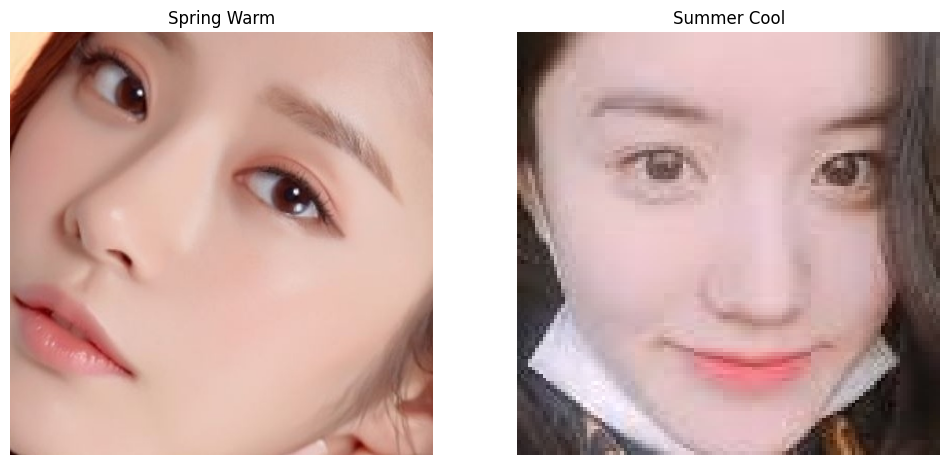

In [37]:
from PIL import Image

img1 = Image.open('test_face/Spring Warm/face_001.jpg')
img2 = Image.open('test_face/Summer Cool/face_005.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].set_title('Spring Warm')
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].set_title('Summer Cool')
axes[1].axis('off')
plt.show()

In [38]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)

test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)

y_pred = model(test_batch)
y_prob = nn.Softmax(1)(y_pred)

probs, indices = torch.max(y_prob, axis=1)

probs = probs.cpu().data.numpy()
indices = indices.cpu().data.numpy()

print(indices)
print(probs)

[1 1]
[0.63223666 0.70151764]


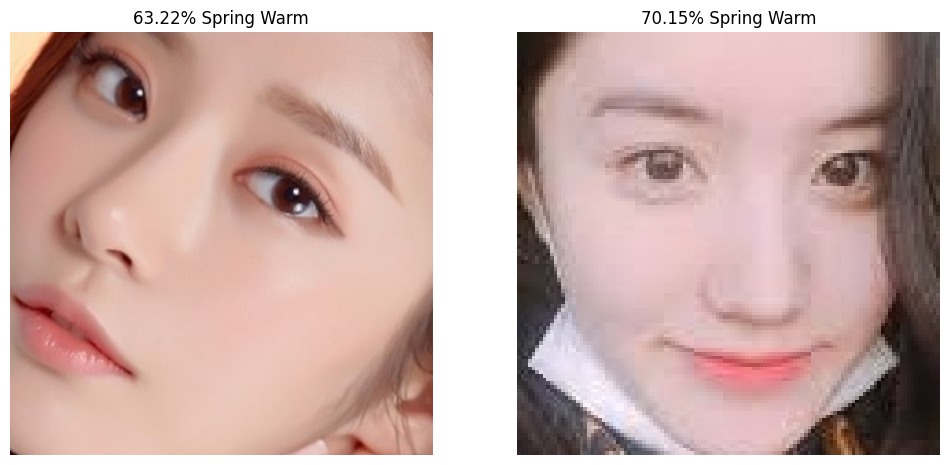

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].set_title(f'{probs[0] * 100:.2f}% {image_datasets["validation"].classes[indices[0]]}')
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title(f'{probs[1] * 100:.2f}% {image_datasets["validation"].classes[indices[1]]}')
axes[1].imshow(img2)
axes[1].axis('off')

plt.show()